In [2]:
from ModelClass import RegressionModel
from DatasetClass import Dataset, DatasetMass
import matplotlib.pyplot as plt
import numpy as np
import itertools
from src.helpers import make_filter_slice

2025-03-02 22:50:02.744449: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [1]:
erik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*H125*.root"
patrik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*Ztt*.root"


In [2]:
dataset = Dataset(file_paths=erik_data, file_name = "erik_data")
dataset.load_data()

print(len(dataset.train_dataset))

#This block of code iterates through the dataset and extracts the pt values of the labels and stores them in a list
data = [labels.numpy()[0] for features, labels in dataset.train_dataset.take(100000)]

plt.hist(data, bins=100, range=(50, 130), histtype='step', label='pt distribution', density=False)
plt.legend(loc='upper right')
plt.title('pt distribution of the dataset')
plt.xlabel('pt')
plt.ylabel('Number of events')
plt.show()



NameError: name 'Dataset' is not defined

In [ ]:
import tensorflow as tf
dataset = DatasetMass(file_name = "data_test")
dataset.load_data()



In [23]:
import tensorflow as tf
  
# Prepare Lorentz mask with broadcasting dimensions
lorentz_mask = tf.constant(dataset.get_lorentz_mask())  # Shape [35]
lorentz_mask = lorentz_mask[tf.newaxis, :]  # Shape [1, 35]

# Get indices for Lorentz features
where_result = tf.where(lorentz_mask)  # Returns shape [n, 2] (row, col indices)
lorentz_indices = where_result[:, 1]
n_vectors = tf.shape(lorentz_indices)[0] // 4
lorentz_indices_4d = tf.reshape(lorentz_indices, (n_vectors, 4))  # [n_vectors, 4]

@tf.function
def augment_lorentz(data, target):
    # Ensure data is at least 2D (batch, features)
    #data = tf.ensure_shape(data, [35, None])
    
    # Generate random beta for each sample in the batch
    beta = tf.random.uniform(shape=(tf.shape(data)[0],), minval=0.0, maxval=1.0)
    gamma = 1.0 / tf.sqrt(1.0 - beta**2)
    
    # Extract 4-vectors using indices
    boosted_data = data
    for i in range(n_vectors):
        vec_indices = lorentz_indices_4d[i]
        pt = data[vec_indices[0]]
        eta = data[vec_indices[1]]
        phi = data[vec_indices[2]]
        E = data[vec_indices[3]]
        
        # Convert to Cartesian coordinates
        px = pt * tf.cos(phi)
        py = pt * tf.sin(phi)
        pz = pt * tf.sinh(eta)
        
        # Apply boost along z-axis
        beta_exp = tf.expand_dims(beta, 1)
        gamma_exp = tf.expand_dims(gamma, 1)
        E_prime = gamma_exp * (E - beta_exp * pz)
        pz_prime = gamma_exp * (pz - beta_exp * E)
        
        # Convert back to eta
        epsilon = 1e-8
        eta_prime = tf.asinh(pz_prime / (pt + epsilon))
         # Update the data tensor
        boosted_data = tf.tensor_scatter_nd_update(
            boosted_data,
            indices=tf.expand_dims(vec_indices, axis=1),
            updates=tf.stack([pt, eta_prime, phi, E_prime], axis=0)
        )
        print(boosted_data)
    
    return boosted_data, target
train_dataset = dataset.train_dataset.map(augment_lorentz)


ValueError: in user code:

    File "/tmp/ipykernel_1026212/3129122831.py", line 46, in augment_lorentz  *
        boosted_data = tf.tensor_scatter_nd_update(

    ValueError: Shapes must be equal rank, but are 0 and 2
    	From merging shape 2 with other shapes. for '{{node while/stack_1}} = Pack[N=4, T=DT_FLOAT, axis=0](while/strided_slice_2, while/Asinh, while/strided_slice_6, while/mul_4)' with input shapes: [], [35,1], [], [35,1].


tf.Tensor(
[False False  True False False False  True False False  True False False
 False False False  True False False False  True False False False  True
 False False False  True False False False False False False False], shape=(35,), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False], shape=(35,), dtype=bool)


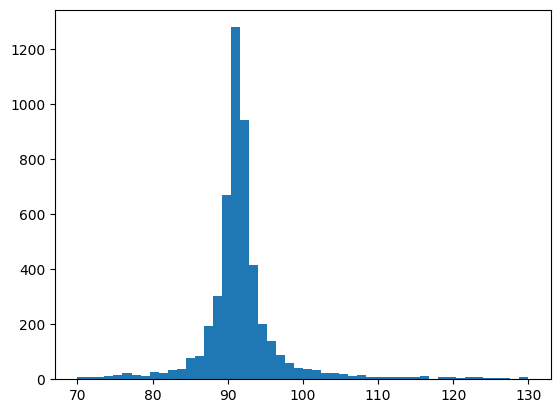

In [8]:

import vector as v

# augmentation
dataset.make_slices(n_slices=1)
slices = dataset.slices 

phi_mask = tf.constant(dataset.get_phi_mask())
lorentz_mask = tf.constant(dataset.get_lorentz_mask())
print(phi_mask)
print(lorentz_mask)

@tf.function
def augment_phi(data, target):
    # generate random rotation angle
    angle = tf.random.uniform(shape=(tf.shape(data)[0],), minval=-np.pi, maxval=np.pi)

    # apply rotation
    data  = tf.where(phi_mask[tf.newaxis, :], data + angle[:, tf.newaxis], data)

    # normalize angles between -pi and pi
    data = tf.where(phi_mask[tf.newaxis, :], tf.math.atan2(tf.sin(data), tf.cos(data)), data)

    return data, target

# sample from the slices
n_events = 5000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

# apply augmentation
new_dataset = new_dataset.map(augment_phi)

batch_dataset = new_dataset.batch(n_events)
#print(batch_dataset.take(1))
#print(type(batch_dataset))
#@tf.function
#def pick_mass(data, targets):
#        return data, targets

features, targets = next(iter(batch_dataset))
masses = targets

import matplotlib.pyplot as plt
plt.hist(masses, range=(70, 130), bins=50)
plt.show()




tf.Tensor(
[False False  True False False False  True False False  True False False
 False False False  True False False False  True False False False  True
 False False False  True False False False False False False False], shape=(35,), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False], shape=(35,), dtype=bool)


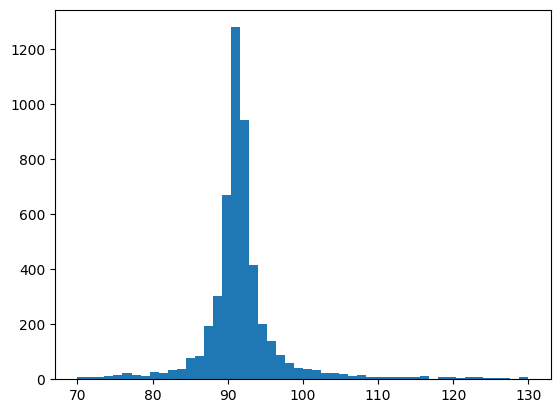

In [ ]:

import vector as v

# augmentation
dataset.make_slices(n_slices=1)
slices = dataset.slices 

phi_mask = tf.constant(dataset.get_phi_mask())
lorentz_mask = tf.constant(dataset.get_lorentz_mask())
print(phi_mask)
print(lorentz_mask)

@tf.function
def augment_phi(data, target):
    # generate random rotation angle
    angle = tf.random.uniform(shape=(tf.shape(data)[0],), minval=-np.pi, maxval=np.pi)

    # apply rotation
    data  = tf.where(phi_mask[tf.newaxis, :], data + angle[:, tf.newaxis], data)

    # normalize angles between -pi and pi
    data = tf.where(phi_mask[tf.newaxis, :], tf.math.atan2(tf.sin(data), tf.cos(data)), data)

    return data, target

@tf.function
def augment_lorentz(data, target):
    beta = tf.random.uniform(shape=(tf.shape(data)[0],), minval=0, maxval=1)

    pxs = tf.where(lorentz_mask[tf.newaxis, :], data[:, 0], 0)
    pys = tf.where(lorentz_mask[tf.newaxis, :], data[:, 1], 0)
    pzs = tf.where(lorentz_mask[tf.newaxis, :], data[:, 2], 0)
    Es = tf.where(lorentz_mask[tf.newaxis, :], data[:, 3], 0)

    return data, target

# sample from the slices
n_events = 5000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

# apply augmentation
new_dataset = new_dataset.map(augment_phi)

batch_dataset = new_dataset.batch(n_events)
#print(batch_dataset.take(1))
#print(type(batch_dataset))
#@tf.function
#def pick_mass(data, targets):
#        return data, targets

features, targets = next(iter(batch_dataset))
masses = targets

import matplotlib.pyplot as plt
plt.hist(masses, range=(70, 130), bins=50)
plt.show()




In [ ]:
dataset = Dataset(file_paths=erik_data, file_name = "erik_data")
dataset.load_data()

print(len(dataset.train_dataset))
param_grid = {
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 30]
}

iterable = list(itertools.product(*param_grid.values()))
for params in iterable:
    model = RegressionModel(dataset=dataset, batch_size=params[0], initial_learning_rate=params[1], n_epochs=params[2])
    model.prepare_dataset()
    model.create_normalizer()
    model.build_model()
    model.train_model(model.train_batch, model.val_batch)
    model.plot_history(model.history)

6523673
Batching datasets...
Building model...
Training model...
Epoch 1/10


2025-01-29 01:07:34.276361: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203865/203865 ━━━━━━━━━━━━━━━━━━━━ 220s 1ms/step - loss: 6972.8779 - mean_squared_error: 6972.8779 - val_loss: 6874.8071 - val_mean_squared_error: 6874.8286
Epoch 2/10
203825/203865 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6946.1182 - mean_squared_error: 6946.1182